## Import Data

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import joblib

from eosce.models import ErsiliaCompoundEmbeddings

## Ersilia Descriptor Model

In [36]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [37]:
train_df

,DrugBankID,SMILES,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_390,embedding_391,embedding_392,embedding_393,embedding_394,embedding_395,embedding_396,embedding_397,embedding_398,embedding_399
0,Compound::DB07558,[H]C(=O)[C@H](CCCC)NC(=O)[C@H](CC(C)C)NC(=O)[C...,0.555787,0.684139,0.512719,-0.529718,0.262826,-0.655200,-0.660008,-0.542136,...,-0.374233,-0.247684,-0.171424,0.751738,0.813677,0.581156,0.583023,0.023468,-0.481377,0.333508
1,Compound::DB00642,NC1=NC(=O)C2=C(NC=C2CCC2=CC=C(C=C2)C(=O)N[C@@H...,-0.392229,-0.408550,-0.678823,-0.117495,0.345655,-0.461185,0.179226,-0.390624,...,0.103734,0.404542,-0.495886,-0.024562,0.537487,-0.723340,-0.179744,-0.217128,0.518866,-0.603604
2,Compound::DB07687,[H][C@]1(N)CC[C@@]([H])(CC1)NC1=NC2=NC=NN2C(NC...,-0.595988,0.566669,0.453570,0.568219,0.629722,-0.558329,-0.581300,0.621745,...,0.524033,-0.575679,-0.583070,-0.175447,0.595868,-0.497308,-0.425932,-0.623063,0.635332,0.630280
3,Compound::DB01116,O=C1N(CC2=CC=CC=C2)C2C[S+]3CCCC3C2N1CC1=CC=CC=C1,0.284446,-0.204648,-0.366842,0.314053,0.005129,0.716794,0.401084,-0.772718,...,0.255622,-0.406962,-0.638894,-0.250029,-0.332250,-0.635454,-0.518743,0.546009,0.286829,-0.728248
4,Compound::DB09212,CC(C(O)=O)C1=CC=C(CC2CCCC2=O)C=C1,0.610174,0.601935,-0.689303,-0.590422,0.741201,-0.624510,-0.437523,-0.668031,...,0.433412,-0.537336,-0.696722,-0.370152,-0.215580,-0.317241,-0.527324,-0.550422,0.400996,-0.569671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040,Compound::DB07838,OC1=C(\C=C2/SC(=S)N(CC3=CC=CC=C3)C2=O)C=CC=C1[...,0.576086,0.531252,-0.397937,0.656185,0.546268,-0.548028,-0.635353,0.616000,...,-0.635258,-0.471979,-0.337811,0.298309,0.678311,0.549808,0.158899,0.603398,-0.587207,0.505850
7041,Compound::DB07267,CC1=CC=CC(=N1)C1=NC(NC2=CC=NC=C2)=C2C=CC=CC2=N1,-0.628725,0.552413,-0.509549,0.533964,0.572574,0.556859,-0.627744,0.587102,...,-0.640469,-0.655582,0.653508,0.587660,0.500923,-0.557616,-0.524073,-0.415384,-0.608517,-0.602539
7042,Compound::DB07473,COC(=O)[C@@H]1CS[C@]2(N1C(=O)C1=CC=CC=C21)C1=C...,0.547474,0.594530,0.598974,0.588209,-0.518837,-0.532142,-0.621101,-0.575629,...,-0.571024,-0.679230,0.520724,0.540047,0.583776,0.552496,-0.426420,-0.364009,0.507542,-0.616206
7043,Compound::DB00977,[H][C@@]12CC[C@@](O)(C#C)[C@@]1(C)CC[C@]1([H])...,-0.274505,-0.261260,-0.074179,0.472879,-0.036972,0.161962,-0.306623,0.011028,...,0.371580,0.385515,-0.458153,0.033768,0.068725,-0.652143,-0.418417,0.122688,0.749156,-0.826212


In [9]:
# Function to calculate Ersilia descriptors
def calculate_ersilia_descriptors(smiles):
    model = ErsiliaCompoundEmbeddings()
    embeddings = model.transform([smiles])
    return embeddings

# Function to preprocess data and create embeddings
def preprocess_data(df):
    # Get the target embeddings
    embeddings = df.iloc[:, 2:].values
    # create Ersilia descriptor columns
    df['ersilia_descriptors'] = df['SMILES'].apply(calculate_ersilia_descriptors)
    df = df.dropna()
    # Extract the descriptors as a NumPy array
    ersilia_descriptors = np.vstack(df['ersilia_descriptors'].values)
    return ersilia_descriptors, embeddings

In [10]:
# The ersilia descriptor is X, our features
# The embeddings is y, our target variable
X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

print("The length of X_train is:", len(X_train))
print("The length of X_test is:", len(X_test))

[10:41:41] Unusual charge on atom 0 number of radical electrons set to zero


The length of X_train is: 7045
The length of X_test is: 1762


Save the ersilia embeddings since it takes a long time to convert them.

In [2]:
# # Specify the directory
directory = 'data/ersilia_embeddings/'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# # Save the variables as text files
# np.savetxt(os.path.join(directory, 'X_train_ersilia1.txt'), X_train)
# np.savetxt(os.path.join(directory, 'y_train_ersilia1.txt'), y_train)
# np.savetxt(os.path.join(directory, 'X_test_ersilia1.txt'), X_test)
# np.savetxt(os.path.join(directory, 'y_test_ersilia1.txt'), y_test)

In [3]:
# Load the variables as NumPy arrays
X_train = np.loadtxt(os.path.join(directory, 'X_train_ersilia1.txt'))
y_train = np.loadtxt(os.path.join(directory, 'y_train_ersilia1.txt'))
X_test = np.loadtxt(os.path.join(directory, 'X_test_ersilia1.txt'))
y_test = np.loadtxt(os.path.join(directory, 'y_test_ersilia1.txt'))

In [4]:
print(X_train.shape)
print(X_train)

(7045, 1024)
[[-0.02310181 -0.04397583 -0.00270081 ... -0.00564575 -0.0881958
   0.04522705]
 [ 0.01737976 -0.01235962 -0.06063843 ... -0.01861572 -0.05303955
  -0.0249176 ]
 [ 0.14355469  0.14587402 -0.13378906 ... -0.04837036  0.01075745
  -0.10162354]
 ...
 [ 0.27685547  0.19360352 -0.2286377  ... -0.02882385 -0.01132202
  -0.08850098]
 [-0.00341797  0.03546143  0.10424805 ... -0.01483154  0.01533508
   0.04705811]
 [ 0.12420654 -0.15637207 -0.07702637 ...  0.03060913 -0.12634277
   0.03120422]]


## Train Model with KNN

In [13]:
from sklearn.neighbors import NearestNeighbors

knn_model = NearestNeighbors(n_neighbors=1, metric='euclidean')
knn_model.fit(X_train)

# Find the indices of the three closest neighbors
distances, indices = knn_model.kneighbors(X_test[0:1, :])

# Extract y outputs of the three closest records
closest_y = y_train[indices]

print("Distances:", distances)
print("Indices:", indices)
print("Closest Embeddings:", closest_y)
# Calculate the average along the first axis (axis=0)
average_output = np.mean(closest_y, axis=1)
print("Length of output:", len(average_output[0]))
print(average_output)

Distances: [[2.02648641]]
Indices: [[2369]]
Closest Embeddings: [[[-0.5735711   0.37308925 -0.5972502   0.52677435  0.6679243
   -0.63901967 -0.6579376  -0.38295385  0.66536933  0.5218315
    0.6715504  -0.5120701  -0.5808884  -0.3503087   0.5405945
    0.36965823 -0.53770477  0.62583035  0.630297    0.5625706
    0.51828784  0.5213486  -0.5484601  -0.5810185   0.58592325
    0.53932476  0.4490064   0.46695018 -0.41771013 -0.38468763
    0.64072925 -0.47134602  0.59219474 -0.6399273   0.6807607
   -0.5356044  -0.6752477  -0.44850904  0.63235694  0.03189552
   -0.53329426 -0.5777384  -0.47765    -0.5281183   0.48861504
   -0.59633154 -0.72116786 -0.6322429  -0.457235    0.49671862
    0.65579665 -0.561651   -0.52495843  0.66287464  0.67703474
    0.6122946  -0.4331531  -0.2926321   0.6382114   0.08333562
   -0.65692335  0.67220896 -0.4622606   0.56335247  0.35866794
   -0.5129243   0.5566984   0.5010553   0.49754664 -0.58450705
    0.62349653  0.42193952 -0.38483226  0.64975804 -0.62787

## Evaluate model on the test set
#### Mean Squared Error

In [14]:
# Use the trained KNN model to find the neighbors for each sample in x_test
distances_test, indices_test = knn_model.kneighbors(X_test)

# Extract y outputs of the three closest records for each sample in x_test
closest_y_test = y_train[indices_test]

# Calculate the average along the first axis for each sample
average_output_test = np.mean(closest_y_test, axis=1)

# Evaluate the performance using mean squared error
mse = mean_squared_error(y_test, average_output_test)
print(f"Mean Squared Error on Test Set: {mse}")

Mean Squared Error on Test Set: 0.3913663663557547


In [15]:
print("Closest y_test:", closest_y_test)

Closest y_test: [[[-0.5735711   0.37308925 -0.5972502  ... -0.44339147 -0.3090781
    0.5482032 ]]

 [[-0.6005462   0.6055812  -0.5242582  ...  0.6410329  -0.52004665
    0.47353834]]

 [[-0.40796453  0.17764696  0.5150937  ...  0.1562344   0.7907612
   -0.2759412 ]]

 ...

 [[ 0.49792987  0.5125827   0.3092664  ...  0.25743964  0.93057483
   -0.29174167]]

 [[ 0.33771178  0.6315384  -0.09745435 ...  0.41898936  0.9237092
   -0.4442458 ]]

 [[ 0.20669067 -0.06862759  0.42335087 ... -0.11597424  0.01466084
   -0.8030096 ]]]


In [16]:
print("Average Ouptut Test:", average_output_test)

Average Ouptut Test: [[-0.5735711   0.37308925 -0.5972502  ... -0.44339147 -0.3090781
   0.5482032 ]
 [-0.6005462   0.6055812  -0.5242582  ...  0.6410329  -0.52004665
   0.47353834]
 [-0.40796453  0.17764696  0.5150937  ...  0.1562344   0.7907612
  -0.2759412 ]
 ...
 [ 0.49792987  0.5125827   0.3092664  ...  0.25743964  0.93057483
  -0.29174167]
 [ 0.33771178  0.6315384  -0.09745435 ...  0.41898936  0.9237092
  -0.4442458 ]
 [ 0.20669067 -0.06862759  0.42335087 ... -0.11597424  0.01466084
  -0.8030096 ]]


#### R Squared Score

In [17]:
# Calculate the R2 score for the entire test set
r2 = r2_score(y_test, average_output_test)
print(f"Overall R2 Score: {r2}")

Overall R2 Score: -0.602214097751973


#### Cosine Similarity

In [18]:
cosine_sim = cosine_similarity(y_test, average_output_test)
print(f"Cosine Similarity: {cosine_sim}")

mean_cosine_similarity = np.mean(cosine_sim)
print(f"Mean Cosine Similarity: {mean_cosine_similarity}")

Cosine Similarity: [[ 1.81782478e-01  2.87880776e-01  2.06405467e-01 ...  1.22499893e-02
   1.02257486e-01 -7.38271515e-03]
 [ 1.75561684e-01  6.41827816e-01  1.69069411e-01 ... -7.33541424e-02
   6.04213682e-02  1.09362871e-01]
 [ 2.44862197e-01  1.99530938e-01  5.68081345e-01 ...  4.16248810e-02
   1.55390032e-01 -2.79334710e-05]
 ...
 [-4.86291148e-04 -9.61921710e-02  8.05401355e-02 ...  9.57151787e-01
   6.09791475e-01  4.67031034e-02]
 [-1.98115239e-02 -1.54097051e-01  8.46437644e-02 ...  5.62622852e-01
   5.33070785e-01  1.30543296e-01]
 [ 1.79976664e-01  2.76109586e-01  3.10341747e-01 ...  3.55006656e-02
   2.02094391e-01  1.06378869e-01]]
Mean Cosine Similarity: 0.11491866426913078


#### Euclidean Distance

In [19]:
euclidean_dist = distance.euclidean(y_test.flatten(), average_output_test.flatten())
print(f"Euclidean Distance: {euclidean_dist}")

Euclidean Distance: 525.1999762067292


Smaller values indicate that the vectors are closer in the Euclidean space, and larger values indicate they are farther apart.

### Visualizations

In [20]:
def col_comparison(embedding_index, original_embeddings=y_test, predicted_embeddings=average_output_test):
    '''Function to compare the original embeddings with the predicted embeddings.
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    embedding_index (int): number specifying the embedding you want to compare. It ranges from 0-399.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embedding_index for both arrays
    embedding_index_y_test = original_embeddings[:, embedding_index]
    embedding_index_mf = predicted_embeddings[:, embedding_index]

    # Create a DataFrame for Seaborn plotting
    emb_df = pd.DataFrame({'Embedding_index_y_test': embedding_index_y_test,
                       'Embedding_index_mf': embedding_index_mf})

    # Plot the regression plot with Pearson correlation
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Embedding_index_y_test', y='Embedding_index_mf', data=emb_df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embedding_{embedding_index}  for Original and Predicted Embeddings')
    plt.xlabel(f'Original Embedding {embedding_index}')
    plt.ylabel(f'Predicted Embedding {embedding_index}')
    plt.show()

    # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embedding_index_y_test, embedding_index_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

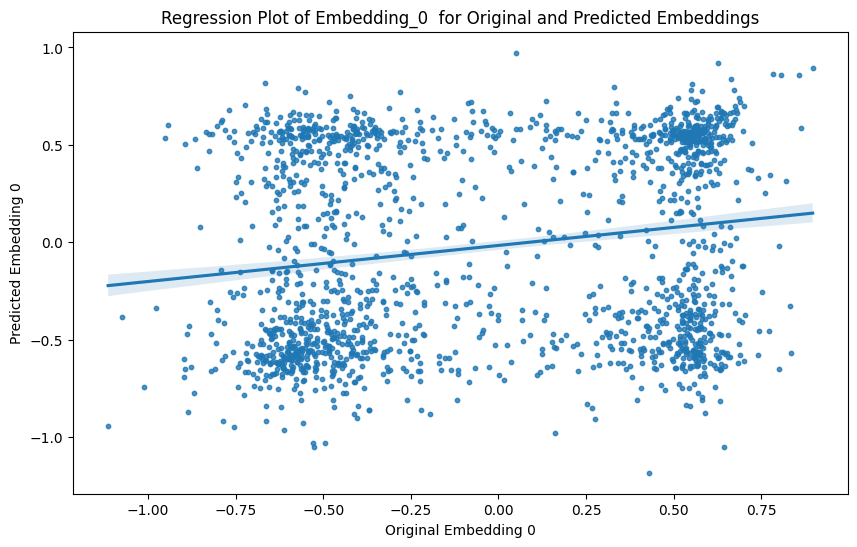

Pearson Correlation: 0.1866


In [21]:
col_comparison(0)

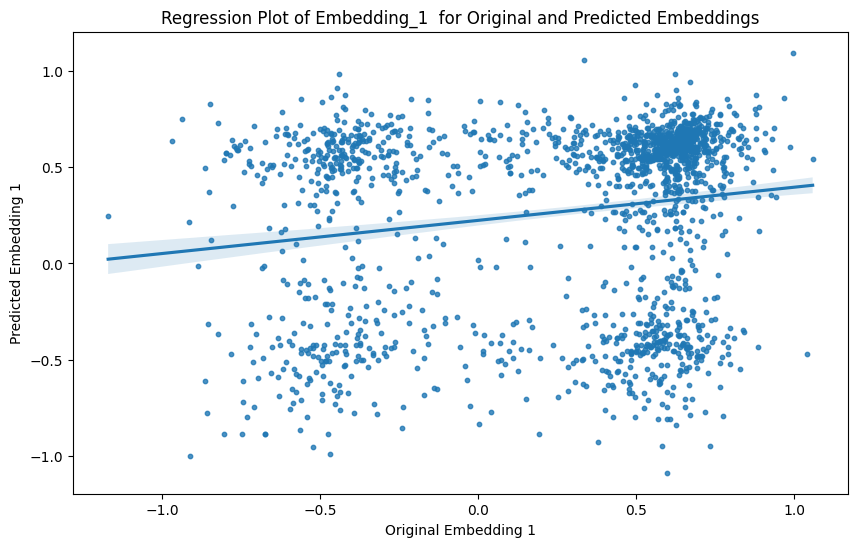

Pearson Correlation: 0.1720


In [22]:
col_comparison(1)

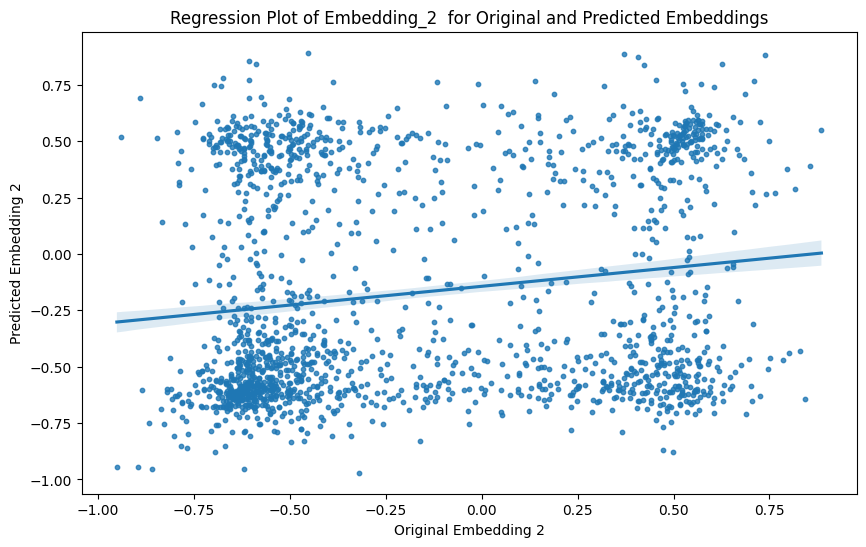

Pearson Correlation: 0.1651


In [23]:
col_comparison(2)

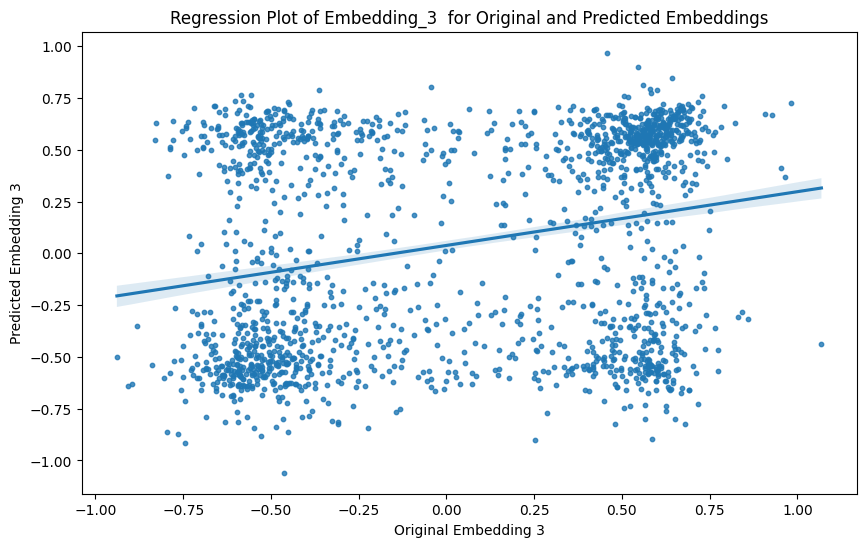

Pearson Correlation: 0.2604


In [24]:
col_comparison(3)

In [25]:
def row_comparison(drug_index, original_embeddings=y_test, predicted_embeddings=average_output_test):
    '''Function to compare the 400 original embeddings with the predicted embeddings for a drug
    It uses a regression plot and Pearson correlation for comparison.
        
    Parameter
    ----------
    drug_index (int): number specifying the drug embedding you want to compare. It ranges from 0-1761.
    original_embeddings (np.array): The original embeddings from the knowledge graph.
    predicted_embeddingns (np.array): The embeddings predicted by the model
    
    Returns
    -------
    pearson_corr (np.array): person correlation score.
    '''
    # Extract embeddings for the specified drug
    embeddings_y_test = original_embeddings[drug_index]
    embeddings_mf = predicted_embeddings[drug_index]

    # Create a DataFrame for Seaborn plotting
    df = pd.DataFrame({'Embeddings_y_test': embeddings_y_test,
                       'Embeddings_mf': embeddings_mf})

    # Plot the regression plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x='Embeddings_y_test', y='Embeddings_mf', data=df, scatter_kws={'s': 10})
    plt.title(f'Regression Plot of Embeddings for Drug {drug_index}')
    plt.xlabel(f'Original Embeddings for Drug {drug_index}')
    plt.ylabel(f'Predicted Embeddings for Drug {drug_index}')
    plt.show()

     # Calculate the Pearson correlation
    pearson_corr = np.corrcoef(embeddings_y_test, embeddings_mf)[0, 1]
    print(f'Pearson Correlation: {pearson_corr:.4f}')

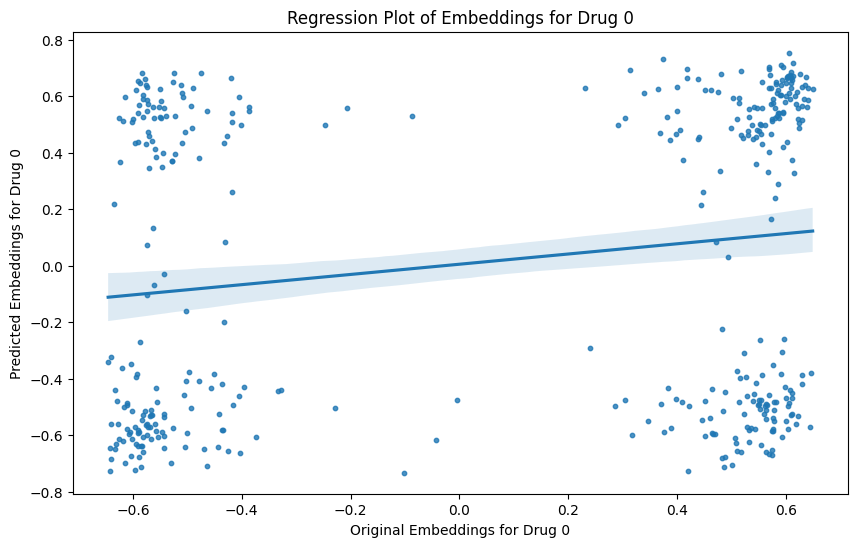

Pearson Correlation: 0.1788


In [26]:
row_comparison(0)

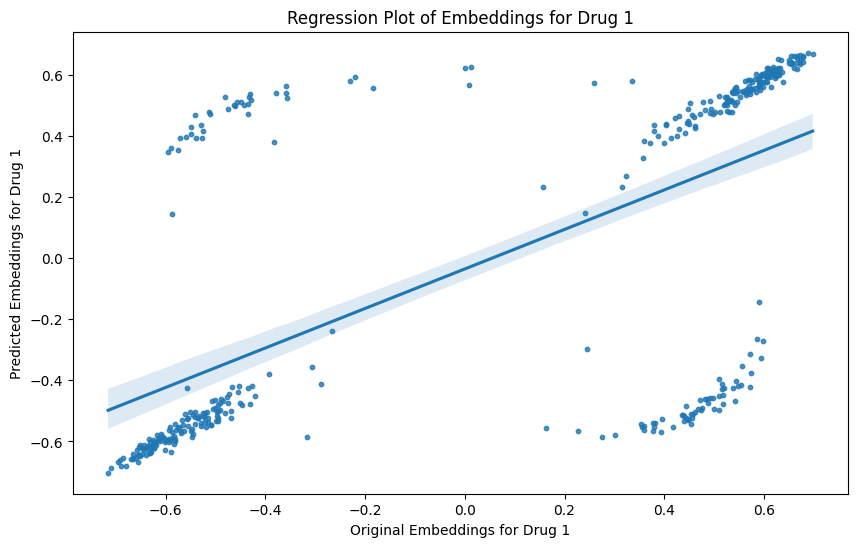

Pearson Correlation: 0.6450


In [27]:
row_comparison(1)

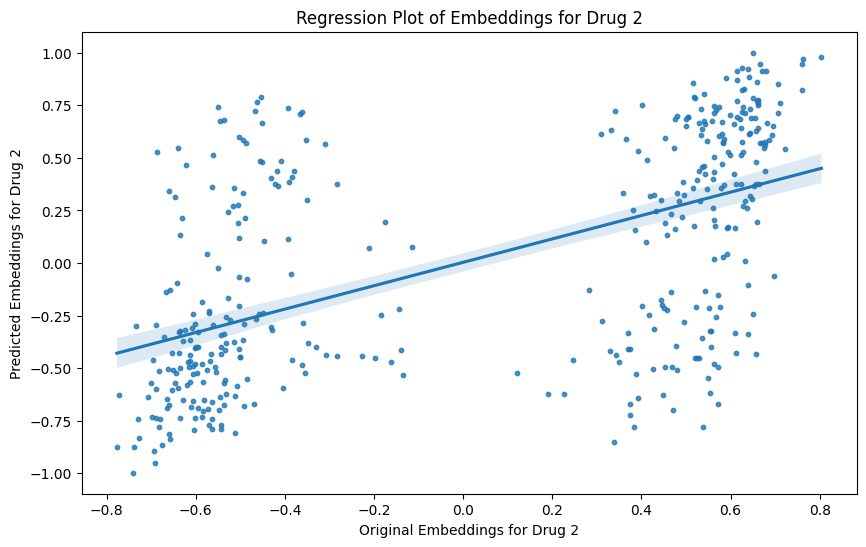

Pearson Correlation: 0.5673


In [28]:
row_comparison(2)

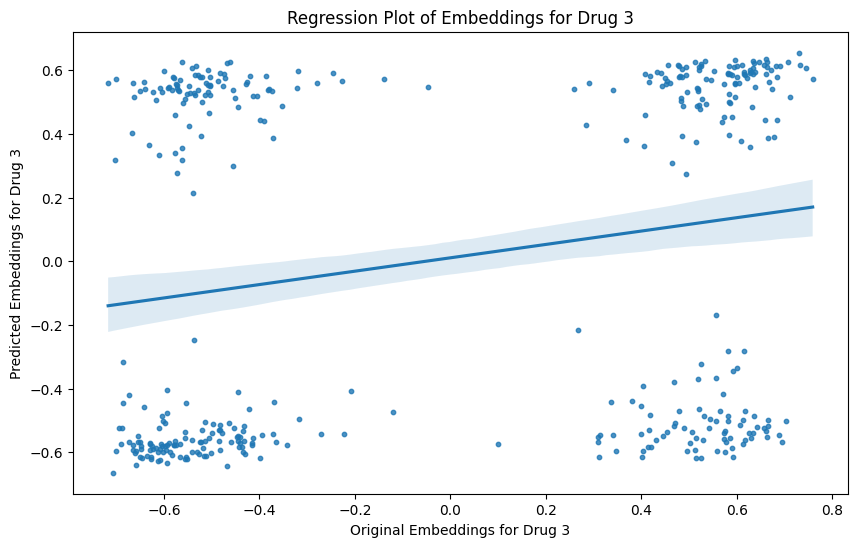

Pearson Correlation: 0.2109


In [29]:
row_comparison(3)

### Save Model

In [30]:
# Save the trained model to a file
joblib.dump(knn_model, 'knn_model_3n.joblib')
# loaded_knn_model = joblib.load('knn_model_3n.joblib')

['knn_model_3n.joblib']